### Napari demo
#### About napari
Napari is an open-source python/Qt-based image viewer developed by developers at or affiliated with the Chan Zuckerberg Institute (CZI), as well as volunteers. Napari targets users viewing and analyzing imaging data in python. It is approximately 1 year old, and is very actively developed, as one can see from their [github](https://github.com/napari/napari) repo.  

Napari is available on pip, and can be installed via `pip install napari`  

Napari is not browser-based; it is not a widget that can be embedded in a notebook. It requires a desktop environment to run, so if you want to use napari on a remote system be sure you have a remote desktop environment set up (e.g., nomachine).

#### This notebook

This notebook will use a toy workflow (generating fake functional imaging data) to demonstrate how to use napari, as well as its limitations. This demo assumes that the user has a recent version of python and the standard python scientific computing stack installed (e.g., `numpy`, `scipy`, `dask`, `matplotlib`). Although it wasn't my original intention, I used napari heavily during the creation of this tutorial. I had to pick a bunch of parameters for the simulated data, and since the data is 4D, I needed an image viewer that worked with that number of dimensions. Using napari was _much_ faster than the alternatives (one plane at a time via matplotlib, or saving files to disk and viewing them with fiji)

### Basic usage of napari in the notebook:

Import napari and it's ready to use... with a caveat. In the notebook, we have to add this `%gui qt` thing.

The order of these operations matters -- `%matplotlib inline` should occur before `%gui qt`. I don't know why exactly. Generally, using Qt-based gui tools (like napari and matplotlib) in the jupyter environment can require strange stuff like this to avoid hiccups.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import napari
# this line is necessary to have non-blocking code in the notebook:
%gui qt 

Use napari to display some random data by creating a `Viewer` and calling the `add_image` method, or by calling `view_image`

In [70]:
# create a viewer, add images later
v = napari.Viewer()

In [2]:
import numpy as np
v.add_image(np.random.random_sample(size=(10,10,10,3)), rgb=True, name='Random floats (rgb)')

# create a viewer and display an image
napari.view_image(np.random.randint(0,255, size=(10,10,10,10,10)),name='Random integers')

<Image layer 'Random floats (rgb)' at 0x7f48e4840250>

### Toy workflow: creating fake functional imaging data
In this workflow, we will generate a simple fake functional imaging dataset, which consists in the following operations:
* Create smooth timeseries (one per cell)
* Create a cell 
* Fill the 4D (time, z ,y , x) volume with time-varying cells and noise

In [3]:
# Define the dimensionality of the data; shrink in x and y on weaker computers
t,z,y,x = 100, 32, 1024, 2048 

# scaling necessary for isotropic voxel sizes
# assume 4 micron z step, .625 micron y and x size
scale = (1, 4, .625, .625) 

# the number of cells we want
num_cells = 1000

#### Space
Here we initialize our anatomical volume, create a cell, and fill the volume with cells.

In [48]:
from scipy.signal import fftconvolve
from skimage.morphology import ball
from scipy.ndimage.interpolation import zoom

vol = np.zeros((z,y,x), dtype='uint16')
# Randomly pick unique locations for cells
cellpos = np.random.choice(np.prod(vol.shape), size=num_cells, replace=False)
# stick 1's where the cells will go
vol.ravel()[cellpos] = 1

# set the radius of the cell
cell_radius = 14
base_cell = ball(cell_radius)
# squish the cell in z, according to the anisotropy of our data
cell = zoom(base_cell.astype('float32'), (scale[2] / scale[1], 1, 1))

# use convolution to stick cells in all the right places
anatomy = fftconvolve(vol.astype('float32'), cell, mode='same')

We just created a bunch of 3D arrays. It would be good to inspect them before we move on to the next part of the workflow. Here I add a bunch of our intermediate images to the active napari viewer so we can get a look at what we just made.

In [6]:
v.add_image(base_cell, name="Isotropic cell", contrast_limits=(0,1))
v.add_image(cell, name="Squished cell", contrast_limits=(0,1))
v.add_image(anatomy, name="Anatomy", scale = scale[1:], contrast_limits=(0,1))

<Image layer 'Anatomy' at 0x7f482cebb4d0>

#### Time
We want our cells to have some temporal dynamics; here we create a function that generates simple smooth signals by smoothly interpolating a short binary sequence.

In [8]:
from scipy.interpolate import interp1d
def random_smooth_vector(num_points=5):
    return interp1d(np.linspace(0,1,num_points), np.random.randint(0,2, size=(num_points)), kind='cubic')

timeseries = np.array([random_smooth_vector()(np.linspace(0,1,t)) for p in cellpos])

Check that our timeseries look reasonable:

[Text(0.5, 0, 'Time'), Text(0.5, 0, 'Time')]

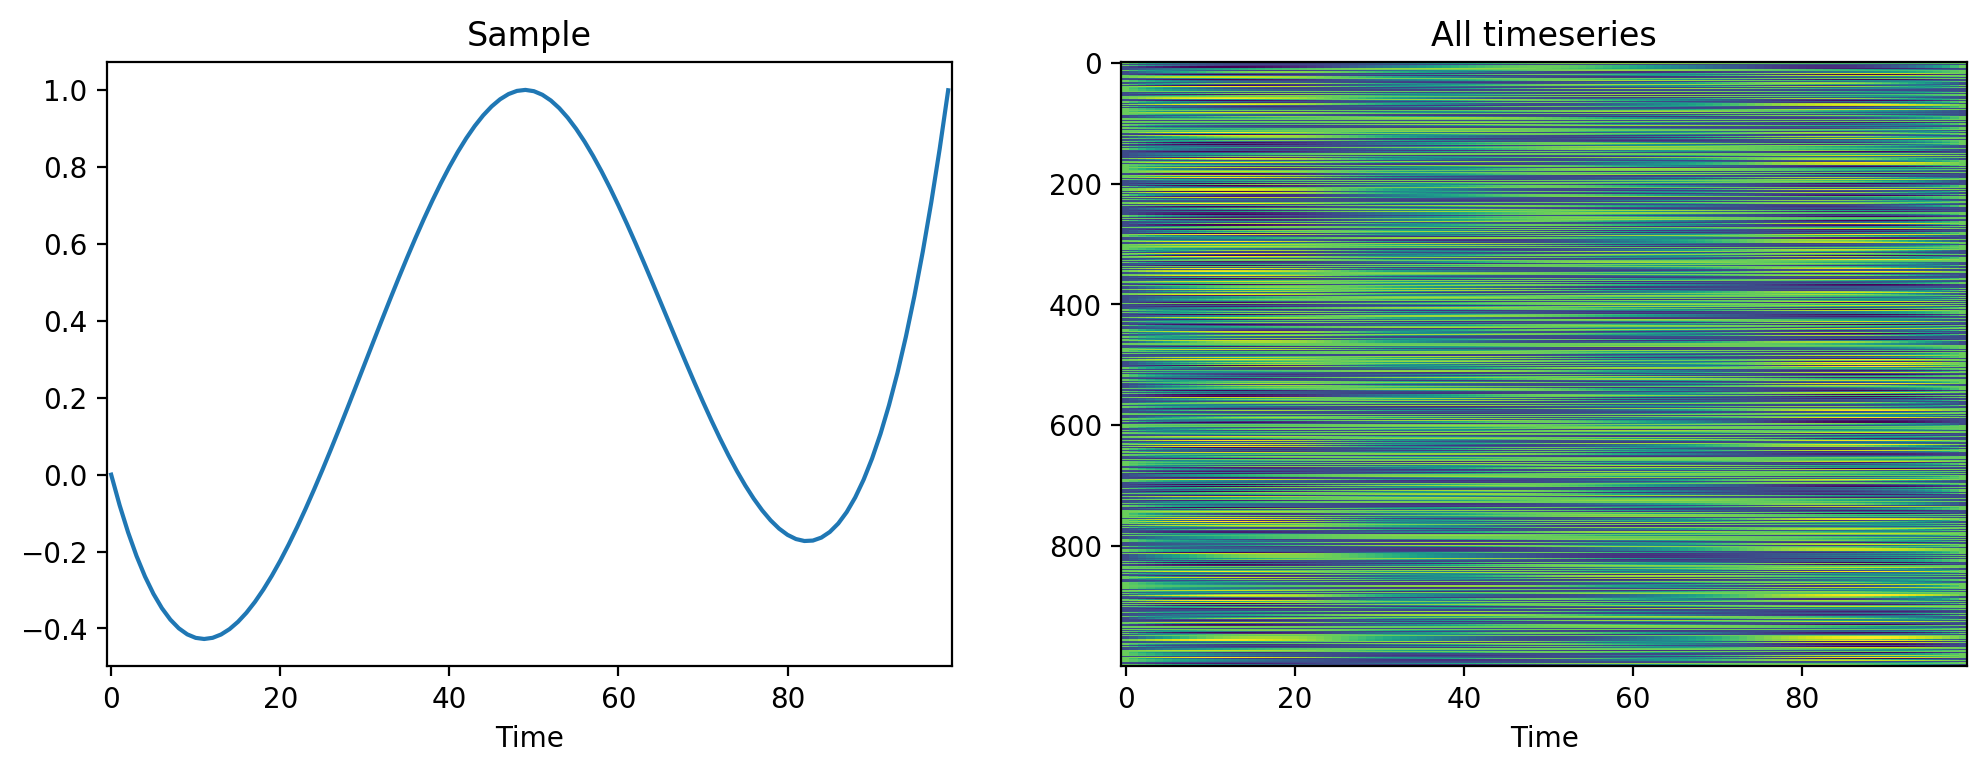

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4), sharex=True, dpi=200)
axs[0].plot(timeseries[0]);
axs[1].imshow(timeseries, aspect='auto')
axs[0].title.set_text('Sample')
axs[1].title.set_text('All timeseries')
[ax.set_xlabel('Time') for ax in axs]


#### Space + Time
Now that we have our timeseries and anatomy, we can put them together. I do this with a function that takes intensities, positions, an output shape, and a cell volumes and returns a 3D volume with some multiplicative, then additive, noise (which emulates imaging conditions). Note that I use `dask.delayed` here to make the function _lazy_. This lets me parallelize the computation of the full dataset later.

In [68]:
from dask import delayed
@delayed
def make_timepoint(intensities, cellpos, shape, cell):
    vol = np.zeros(shape, dtype='float32')
    vol.ravel()[cellpos] = intensities # put intensities in the right place    
    convolved = fftconvolve(vol, cell, mode='same') # spread out intensities
    convolved *= (15 + np.random.standard_normal(size=convolved.shape).astype('float32') ) # multiplicative noise
    convolved += np.random.poisson(90, size=convolved.shape).astype('uint16') # additive noise
    return convolved.astype('uint16')

#### Check out a sample timepoint
Before computing the entire dataset, we should compute a single timepoint and examine it.

In [69]:
%%time
test = make_timepoint(intensities=timeseries[:,3], cellpos=cellpos, shape=(z,y,x), cell=cell).compute()

CPU times: user 1.46 s, sys: 496 ms, total: 1.95 s
Wall time: 10.9 s


In [71]:
v.add_image(test, name ='Test timepoint', scale=scale[1:])

<Image layer 'Test timepoint' at 0x7f4895beb810>

#### Compute entire dataset
If that single timepoint looks good, we can go ahead and use the `make_timepoint` function to define an entire 4D volume (lazily, using dask).

In [30]:
import dask.array as da
dataset = da.stack([da.from_delayed(make_timepoint(timeseries[:,t_], cellpos, (z,y,x), cell), shape=(z,y,x), dtype='uint16') for t_ in range(t)])
dataset

,Array,Chunk
Bytes,26.84 GB,268.44 MB
Shape,"(100, 32, 1024, 2048)","(1, 32, 1024, 2048)"
Count,300 Tasks,100 Chunks
Type,float32,numpy.ndarray


This dataset is a little big, so I set up a local dask cluster to transparently scale out the computation of the full dataset.

In [31]:
from distributed import Client, LocalCluster
cl = Client(LocalCluster(host=''))
cl

Client Scheduler: tcp://10.150.100.225:46391 Dashboard: http://10.150.100.225:8787/status,Cluster Workers: 9 Cores: 72 Memory: 810.17 GB


In [32]:
%%time
result = dataset.compute()

CPU times: user 19.4 s, sys: 35.4 s, total: 54.8 s
Wall time: 1min 28s


#### Visualize data and get ROI
In addition to the image layer we have been using for viewing images, napari has a "shapes" layer that allows you to annotate a region with different shapes. We will draw some shapes and use them to get ROI timeseries from our full dataset.

In [34]:
v = napari.view_image(result, scale=scale[1:])
shapes = v.add_shapes()

A line plot is the natural way to display a timeseries. Napari can't display line plots, but it gives us enough information to do it ourselves with matplotlib. All we need is a function that converts the coordinates of a shape into an index into our data. This is super easy for rectangular ROI; for circular ROI, the function would need to be a little more sophisticated.

In [42]:
# convert a set of points defining a rectangular ROI to a tuple of slices.
def rectToSlices(points, scaling):
        pts = (points / scaling).astype('int')                
        start, stop =  pts.min(0), 1 + pts.max(0)
        results = tuple(slice(a,b) for a,b in zip(start, stop))
        return results

With our function, we can grab the data under the areas where we drew our ROI and plot the mean timeseries in matplotlib. Here I use a static, inline plot, but I'm pretty sure you could write a dynamic plot that updates whenever the shapes in the napari viewer are changed.

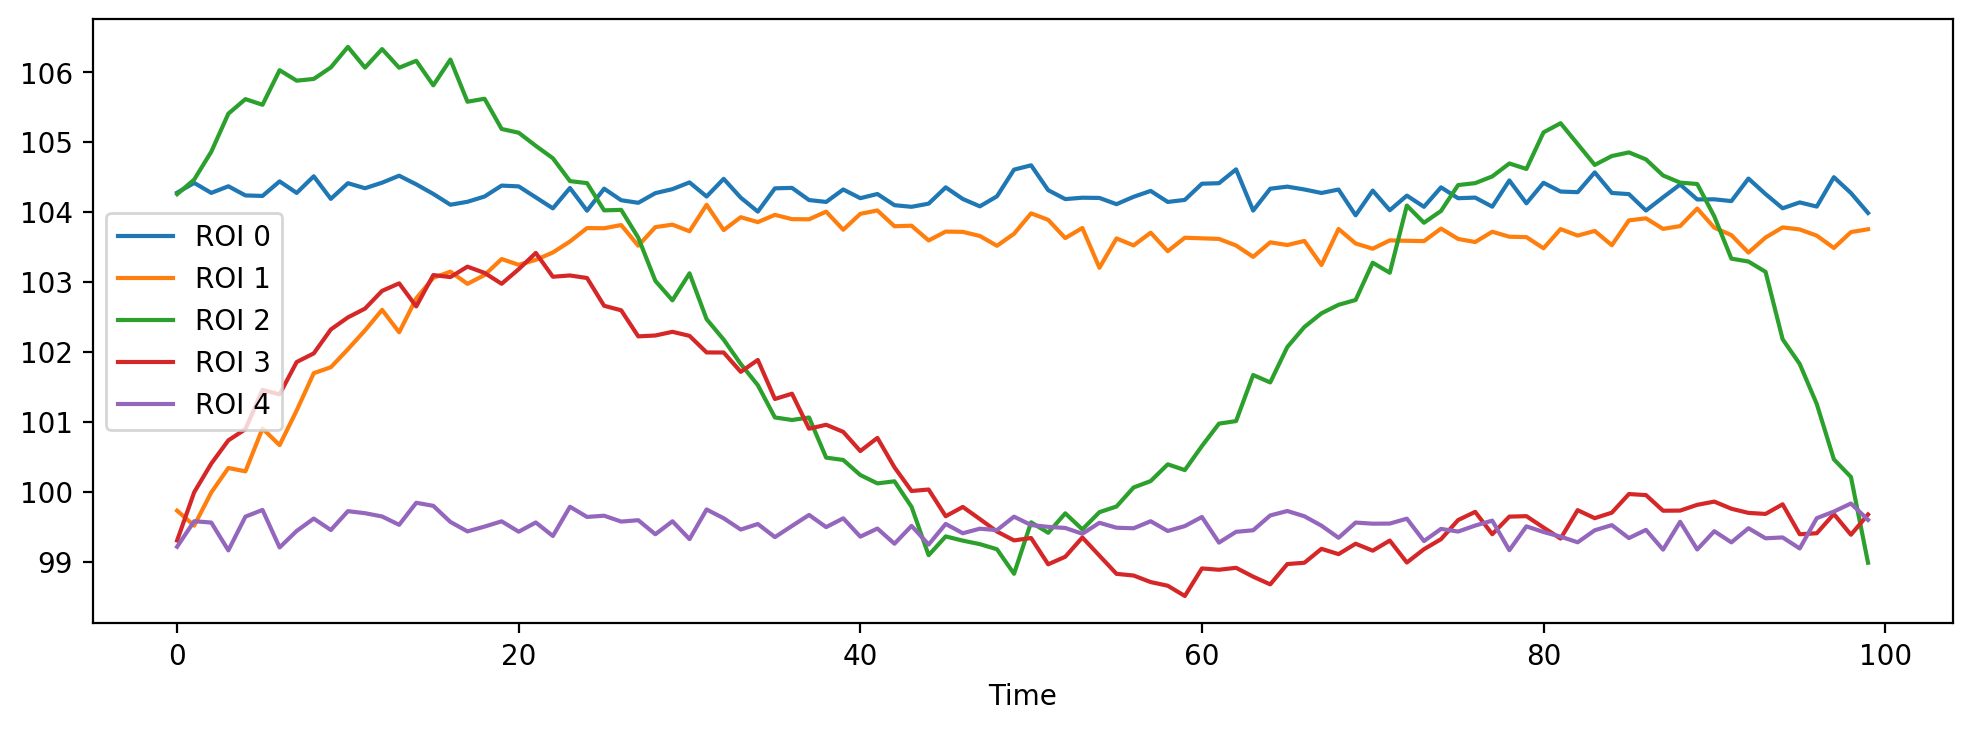

In [47]:
slices = [rectToSlices(d, np.array(scale)) for d in shapes.data]
fig, axs = plt.subplots(figsize=(12,4), dpi=200)
for ind,sl in enumerate(slices):
    axs.plot(result[:, sl[1], sl[2], sl[3]].mean((1,2,3)), label=f'ROI {ind}')
axs.set_xlabel('Time')
axs.legend()

### Recap
* Use napari for visualizing your images.
* Napari is changing rapidly, so don't get too comfortable with certain details.
* If you have problems / features you want added, talk to me or raise issues at https://github.com/napari/napari/issues. The napari team is very responsive.
* Missing features (as of napari v0.2.8) : non-orthogonal slicing, a proper coordinate space model, proper lazy image loading. But this stuff will get added eventually, I hope.